In [1]:
import sys
import numpy as np
np.random.seed(0)

from keras.layers import Input, Dense, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K
from keras.losses import mean_squared_error

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:81:00.0)


## Generate some synthetic data

In [2]:
N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output

In [3]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 8e0  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 3e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

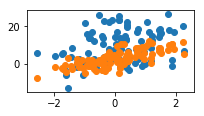

In [4]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

## Use an simple "transparent" layer to add the log_vars and access them later

In [5]:
class LogVarLayer(Layer):
    def __init__(self,nb_outputs=2,**kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(LogVarLayer, self).__init__(**kwargs)
    
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(LogVarLayer, self).build(input_shape)
    
    def call(self,inputs):
        #NOOP
        return inputs

## Define a class for the multi-loss function, we will use them through the classical keras scheme (compile+fit)

In [6]:
class LossFunction(object):
    # Ugly, to be cleaned later. 
    def __init__(self,log_var1,log_var2):
        self.log_var1 = log_var1
        self.log_var2 = log_var2
        
    def MSE_loss_sigma1(self, y_true, y_pred): 
        precision = K.exp(-self.log_var1[0])
        return K.sum(precision * mean_squared_error(y_true,y_pred) + self.log_var1[0], -1)
    
    def MSE_loss_sigma2(self, y_true, y_pred):
       
        precision = K.exp(-self.log_var2[0])
        return K.sum(precision * mean_squared_error(y_true,y_pred) + self.log_var2[0], -1)
                    
                    

## Define the model

In [7]:
inp = Input(shape=(Q,), name='inp')
x = Dense(nb_features, activation='relu')(inp)
log_var = LogVarLayer()(x)
y1_pred = Dense(D1)(x)
y2_pred = Dense(D2)(x)

model = Model(inp, [y1_pred, y2_pred,log_var])

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inp (InputLayer)                 (None, 1)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          2048        inp[0][0]                        
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             1025        dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             1025        dense_1[0][0]                    
___________________________________________________________________________________________

In [9]:
sigma = model.layers[-1].log_vars
lf = LossFunction(sigma[0],sigma[1])

In [10]:
model.compile(optimizer='adam', loss=[lf.MSE_loss_sigma1,lf.MSE_loss_sigma2,None])

In [11]:
hist = model.fit([X], [Y1, Y2], epochs=nb_epoch, batch_size=batch_size, verbose=0)

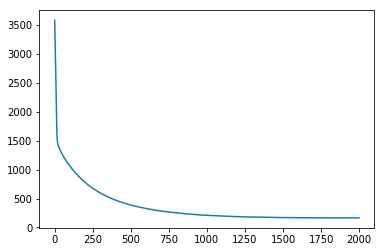

In [12]:
pylab.plot(hist.history['loss'])

In [38]:
for log_var in sigma:
    print(np.exp(log_var[0].eval())**0.5)

7.84161566766
2.75054345396
